100%|██████████| 45/45 [00:01<00:00, 37.87it/s]


Node target asli: 1


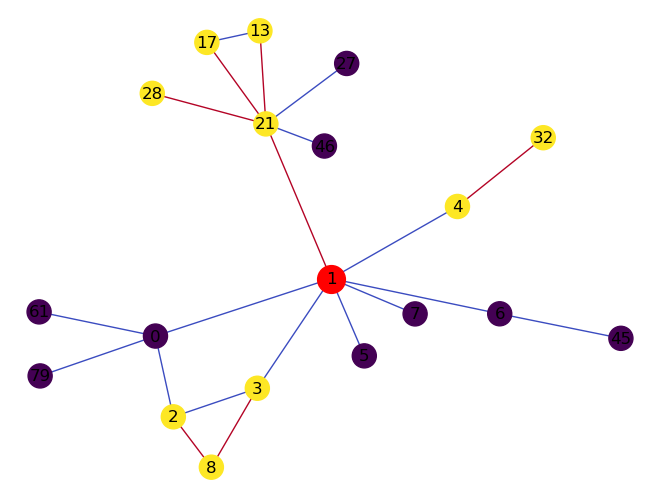

In [19]:
from graphxai.datasets import ShapeGGen
from graphxai.gnn_models.node_classification.testing import GCN_2layer
from graphxai.visualization.explanation_vis import visualize_node_explanation
from graphxai.explainers import GNNExplainer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1. Load synthetic dataset
dataset = ShapeGGen(num_graphs=1, task='node', make_explanations=False)
data = dataset.graph
data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)

# 2. Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_2layer(
    hidden_channels=16,
    input_feat=data.x.shape[1],
    classes=int(data.y.max().item()) + 1
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Train model pada data yang sama
data = data.to(device)
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# 4. Pilih node target dengan label 1 (fraud)
target_node = (data.y == 1).nonzero(as_tuple=True)[0][0].item()

# 5. Explain dengan GNNExplainer
model.eval()
explainer = GNNExplainer(model)
exp = explainer.get_explanation_node(
    node_idx=target_node,
    x=data.x,
    edge_index=data.edge_index,
    label=data.y
)
print("Node target asli:", exp.node_idx)
# 6. Visualisasi hasil explainability
# visualize_node_explanation(exp, show=True, connected=False)
exp.visualize_node(
    num_hops=1,                 # jumlah hops asli dari explainer
    graph_data=data,            # graf lengkap untuk konteks
    additional_hops=1,          # tampilkan 1-hop ekstra dari sekeliling subgraf
    heat_by_exp=True,           # aktifkan pewarnaan berdasarkan importance
    heat_by_prescence=False,    # tidak hanya menyorot kehadiran saja
    show=True,                  # langsung tampilkan visualisasi
    show_node_labels=True       # tampilkan label angka node
)